In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

data_file_path = './data/btc_usdt_data.csv'

gdd.download_file_from_google_drive(file_id='1y22f1z5rww1urbgeZlTzRQBKWVBzvLt5',
                                    dest_path=data_file_path)

In [ ]:
import pandas as pd

df = pd.read_json(data_file_path)

df

In [ ]:
!pip3 install keras
!pip3 install tensorflow

In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [2]:
from data_preprocessing import get_data_for_model, get_future_data

In [ ]:
df

In [3]:
import boto3

s3_client = boto3.client('s3')

data_extractor_bucket_prefix = 'data-extractor-bucket'
data_extractor_bucket_name = None

for bucket in s3_client.list_buckets()['Buckets']:
    if bucket['Name'].startswith(data_extractor_bucket_prefix):
        data_extractor_bucket_name = bucket['Name']


In [4]:
if data_extractor_bucket_name is not None:
    extracted_files = sorted(s3_client.list_objects_v2(Bucket=data_extractor_bucket_name)['Contents'], key=lambda k: k['LastModified'])

DATA_FILES_PREFIXES = ['BTCUSDT','ETHUSDT']
dict_of_files = {}


for extracted_file in extracted_files:
    for data_file_prefix in DATA_FILES_PREFIXES:
        if data_file_prefix not in dict_of_files and extracted_file['Key'].startswith(data_file_prefix):
            dict_of_files[data_file_prefix] = extracted_file['Key']
    if len(dict_of_files.keys()) == len(DATA_FILES_PREFIXES):
        print('Found all files')
        break


Found all files


In [5]:
dict_of_train_data = {}

for k, v in dict_of_files.items():
    dict_of_train_data[k] = pd.read_json(f's3://{data_extractor_bucket_name}/{v}')

In [6]:
df = dict_of_train_data['BTCUSDT']

In [7]:
df

Open      High       Low     Close       Volume
2017-08-17 04:00:00   4261.48   4313.62   4261.32   4308.83    47.181009
2017-08-17 05:00:00   4308.83   4328.69   4291.37   4315.32    23.234916
2017-08-17 06:00:00   4330.29   4345.45   4309.37   4324.35     7.229691
2017-08-17 07:00:00   4316.62   4349.99   4287.41   4349.99     4.443249
2017-08-17 08:00:00   4333.32   4377.85   4333.32   4360.69     0.972807
...                       ...       ...       ...       ...          ...
2020-10-28 16:00:00  13221.26  13221.50  13043.21  13142.02  5267.225157
2020-10-28 17:00:00  13142.02  13219.00  13000.01  13182.88  4071.954897
2020-10-28 18:00:00  13182.89  13240.00  13134.33  13209.86  2630.685999
2020-10-28 19:00:00  13209.87  13255.00  13145.38  13165.31  3068.601046
2020-10-28 20:00:00  13165.32  13202.90  13151.07  13196.20   434.659346

[27941 rows x 5 columns]

In [8]:
number_of_features = 13
start_lag = 12
end_lag = start_lag + number_of_features
num_steps = 3

X, y = get_data_for_model(df, start_lag=start_lag, end_lag=end_lag)
future_data = get_future_data(df, start_lag=start_lag, end_lag=end_lag)
future_data = X.tail(future_data.shape[0]+(num_steps-future_data.shape[0]%num_steps))
x_sc = MinMaxScaler(feature_range = (0, 1))
y_sc = MinMaxScaler(feature_range = (0, 1))
x_sc.fit(X.append(future_data).values.reshape(-1,1))
y_sc.fit(y.values.reshape(-1,1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [9]:
future_data.shape

(15, 13)

In [10]:
X = X[len(X)%(number_of_features*num_steps):]
y = y[len(y)%(number_of_features*num_steps):]

In [11]:
X_scaled = x_sc.transform(X.values.reshape(-1,number_of_features))
y_scaled = y_sc.transform(y.values.reshape(-1,1))
future_data_sc = x_sc.transform(future_data.values.reshape(-1,number_of_features))

In [12]:

X_scaled_shaped = np.reshape(X_scaled, newshape=(-1, num_steps, number_of_features))
y_scaled_shaped = np.reshape(y_scaled, newshape=(-1, num_steps, 1))
future_data_sc_shaped = np.reshape(future_data_sc, newshape=(-1, num_steps, number_of_features))

In [13]:
len(X_scaled_shaped), len(y_scaled_shaped)

(9295, 9295)

In [14]:
train_ind = int(0.8*len(X_scaled_shaped))
train_X = X_scaled_shaped[:train_ind]
train_y = y_scaled_shaped[:train_ind]
test_X = X_scaled_shaped[train_ind:]
test_y = y_scaled_shaped[train_ind:]

In [15]:
model = Sequential()
model.add(LSTM(50, activation='tanh', input_shape=(num_steps, number_of_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = num_steps))
model.compile(optimizer = 'adam', loss = 'mse')

In [16]:
model.fit(train_X, train_y, epochs=20, batch_size=32)

Epoch 1/20
233/233 [==============================] - 4s 15ms/step - loss: 0.0084
Epoch 2/20
233/233 [==============================] - 4s 15ms/step - loss: 0.0019
Epoch 3/20
233/233 [==============================] - 3s 15ms/step - loss: 0.0015
Epoch 4/20
233/233 [==============================] - 3s 14ms/step - loss: 0.0013
Epoch 5/20
233/233 [==============================] - 4s 15ms/step - loss: 0.0012
Epoch 6/20
233/233 [==============================] - 4s 15ms/step - loss: 0.0011
Epoch 7/20
233/233 [==============================] - 3s 15ms/step - loss: 9.6489e-04
Epoch 8/20
233/233 [==============================] - 3s 15ms/step - loss: 9.0477e-04
Epoch 9/20
233/233 [==============================] - 3s 15ms/step - loss: 8.5013e-04
Epoch 10/20
233/233 [==============================] - 4s 15ms/step - loss: 8.3762e-04
Epoch 11/20
233/233 [==============================] - 3s 14ms/step - loss: 7.9915e-04
Epoch 12/20
233/233 [==============================] - 4s 15ms/step - loss: 

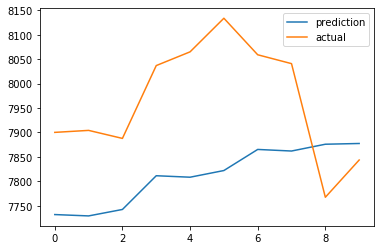

In [17]:
plt.plot(y_sc.inverse_transform(model.predict(test_X)).ravel()[:10], label="prediction")
plt.plot(y_sc.inverse_transform(test_y.ravel().reshape(-1,1))[:10], label="actual")
plt.legend()

In [19]:
mean_absolute_error(y_sc.inverse_transform(model.predict(test_X)).ravel(), y_sc.inverse_transform(test_y.ravel().reshape(-1,1)))

197.88325724305724

In [ ]:
y_sc.inverse_transform(model.predict(future_data_sc_shaped)).ravel()[-12:]

In [ ]:
future_data_sc_shaped